In [1]:
import numpy
from matplotlib import pyplot
import monte_carlo

In [2]:
edges =  [((0,1),-1.0), ((1,2), -1.0), ((2,3), -1.0), ((3,4), -1.0)]
biases = [1.0, 0.0, 0.0, 0.0, 0.0]

## Test beta

In [5]:
betas = [0.1, 0.5, 1.0, 2.5, 5.0, 10.0, 20.0, 40.0]

In [6]:
q_data = numpy.zeros(len(betas))
for i, beta in enumerate(betas):
    results = monte_carlo.run_quantum_monte_carlo_and_measure_spins(beta, 1000, 1000, edges, biases, (-1.0, 1.0), sampling_freq=25)
    q_data[i] = numpy.mean(results, axis=0)

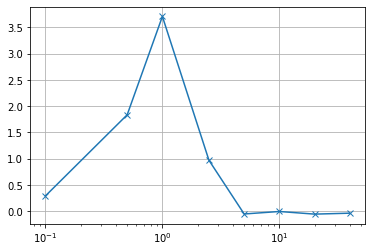

In [7]:
pyplot.plot(betas, q_data, 'x-')
pyplot.xscale('log')
pyplot.grid()
pyplot.show()

In [8]:
data = numpy.zeros(len(betas))
for i, beta in enumerate(betas):
    results = monte_carlo.run_monte_carlo(beta, 1000, 1000, edges, biases)
    results = numpy.asarray([state for _, state in results])
    results = numpy.sum((results * 2) - 1, axis=-1)
    data[i] = numpy.mean(results, axis=0)

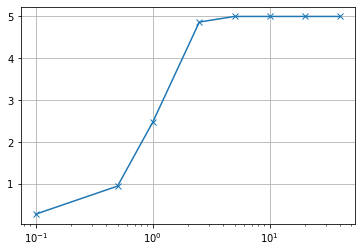

In [9]:
pyplot.plot(betas, data, 'x-')
pyplot.xscale('log')
pyplot.grid()
pyplot.show()

## Test convergence

In [10]:
timesteps = [10, 50, 100, 500, 1000, 5000, 10000]
beta = 5.0

In [11]:
q_data_conv = numpy.zeros(len(timesteps))
for i, ts in enumerate(timesteps):
    results = monte_carlo.run_quantum_monte_carlo_and_measure_spins(beta, ts, 1000, edges, biases, (-1.0, 1.0))
    q_data_conv[i] = numpy.mean(results, axis=0)

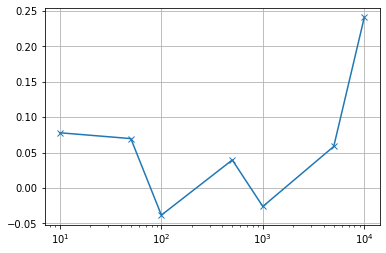

In [12]:
pyplot.plot(timesteps, q_data_conv, 'x-')
pyplot.xscale('log')
pyplot.grid()
pyplot.show()

In [13]:
data_conv = numpy.zeros(len(timesteps))
for i, beta in enumerate(timesteps):
    results = monte_carlo.run_monte_carlo(beta, ts, 1000, edges, biases)
    results = numpy.asarray([state for _, state in results])
    results = numpy.sum((results * 2) - 1, axis=-1)
    data_conv[i] = numpy.mean(results, axis=0)

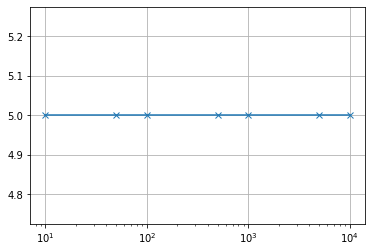

In [14]:
pyplot.plot(timesteps, data_conv, 'x-')
pyplot.xscale('log')
pyplot.grid()
pyplot.show()

## Exact Diagonalization

In [15]:
import scipy.linalg

In [16]:
ham = numpy.zeros((2**len(biases), 2**len(biases)))
for i in range(2**len(biases)):
    state = [(i >> j) & 1 for j in range(len(biases))]
    h = 0.0
    for s, b in zip(state, biases):
        if s:
            h -= b
    for (vara, varb), j in edges:
        if state[vara] == state[varb]:
            h += j
        else:
            h -= j
    ham[i,i] = h

spin_diag = []
for i in range(2**len(biases)):
    state = [(i >> j) & 1 for j in range(len(biases))]
    spin_diag.append(numpy.sum(numpy.asarray(state)*2 - 1))
spin_op = numpy.diag(spin_diag)

In [17]:
ed_data = []
for beta in betas:
    expm = scipy.linalg.expm(-beta*ham)
    ed_data.append(numpy.trace(spin_op @ expm) / numpy.trace(expm))

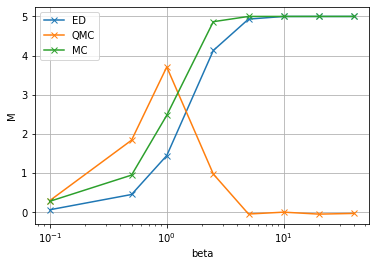

In [18]:
pyplot.plot(betas, ed_data, 'x-', label="ED")
pyplot.plot(betas, q_data, 'x-', label="QMC")
pyplot.plot(betas, data, 'x-', label="MC")
pyplot.xscale('log')
pyplot.legend()
pyplot.grid()
pyplot.xlabel("beta")
pyplot.ylabel("M")
pyplot.savefig("compare.png")
pyplot.show()

## Error bars

In [25]:
qmeans = []
qvars = []
for i, beta in enumerate(betas):
    results = monte_carlo.run_quantum_monte_carlo_and_measure_spins_and_variance(beta, 10000000, 1, edges, biases, (-1.0, 1.0), sampling_freq=10000)[0]
    qmeans.append(results[0])
    qvars.append(numpy.sqrt(results[1]))

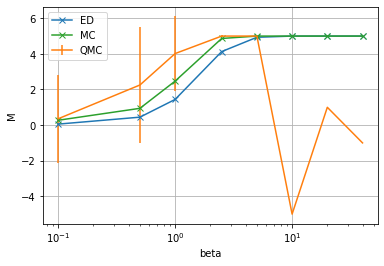

In [26]:
pyplot.plot(betas, ed_data, 'x-', label="ED")
pyplot.errorbar(betas, qmeans, yerr=qvars, label="QMC")
pyplot.plot(betas, data, 'x-', label="MC")
pyplot.xscale('log')
pyplot.legend()
pyplot.grid()
pyplot.xlabel("beta")
pyplot.ylabel("M")
pyplot.savefig("compare.png")
pyplot.show()